In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tools.eval_measures import rmse

# To suppress warnings :
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [2]:
# from google.colab import drive

In [3]:
# drive.mount('/content/drive/')

# READING ALL THE FILES AND COMBINING THEM TOGETHER

In [4]:
Agri_df = pd.read_csv('Agri.csv', index_col=0,parse_dates= True)
Agri_df.index.freq = 'YS'
Gd_df = pd.read_csv('Gd.csv', index_col=0,parse_dates= True)
Gd_df.index.freq = 'YS'
Manu_df = pd.read_csv('Manu.csv', index_col=0,parse_dates= True)
Manu_df.index.freq = 'YS'
indus_df = pd.read_csv('indus.csv', index_col=0,parse_dates= True)
indus_df.index.freq = 'YS'
df = Agri_df.join(Gd_df).join(Manu_df).join(indus_df)

In [5]:
df

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction)
Year,,,,
1961-01-01,1749520.000,3.923244e+10,15.353836,21.434844
1962-01-01,1764820.000,4.216148e+10,15.863298,22.052600
1963-01-01,1761540.000,4.842192e+10,15.752388,21.879476
1964-01-01,1767120.000,5.648029e+10,14.850740,20.955289
1965-01-01,1771770.000,5.955485e+10,15.010908,21.655105
...,...,...,...,...
2017-01-01,1792356.040,2.651470e+12,15.018239,26.500017
2018-01-01,1791155.640,2.702930e+12,14.881531,26.412092
2019-01-01,1790449.469,2.831550e+12,13.473618,24.596458


In [6]:
df.head()

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction)
Year,,,,
1961-01-01,1749520.0,3.923244e+10,15.353836,21.434844
1962-01-01,1764820.0,4.216148e+10,15.863298,22.052600
1963-01-01,1761540.0,4.842192e+10,15.752388,21.879476
1964-01-01,1767120.0,5.648029e+10,14.850740,20.955289
1965-01-01,1771770.0,5.955485e+10,15.010908,21.655105


In [7]:
df.tail()

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction)
Year,,,,
2017-01-01,1792356.040,2.651470e+12,15.018239,26.500017
2018-01-01,1791155.640,2.702930e+12,14.881531,26.412092
2019-01-01,1790449.469,2.831550e+12,13.473618,24.596458
2020-01-01,1790450.764,2.667690e+12,13.683385,24.531066
2021-01-01,1790451.000,3.173400e+12,14.070225,25.871801


In [8]:
#SHAPE OF DATSET
df.shape

(61, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 1961-01-01 to 2021-01-01
Freq: AS-JAN
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Agricultural land (sq. km)            61 non-null     float64
 1   GDP (current US$)                     61 non-null     float64
 2   Manufacturing value added (% of GDP)  61 non-null     float64
 3   Industry (including construction)     61 non-null     float64
dtypes: float64(4)
memory usage: 4.4 KB


In [10]:
df.describe()

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction)
count,6.100000e+01,6.100000e+01,61.000000,61.000000
mean,1.796969e+06,7.098887e+11,15.799919,25.962002
std,1.489476e+04,8.701699e+11,1.066931,2.939175
min,1.749520e+06,3.923244e+10,13.231861,20.089443
25%,1.790451e+06,1.027170e+11,15.102549,24.400263
50%,1.797570e+06,2.960420e+11,15.838487,26.519293
75%,1.808740e+06,9.402600e+11,16.597596,27.628201
max,1.815860e+06,3.173400e+12,17.865851,31.136719


In [11]:
df.isna().sum()

Agricultural land (sq. km)              0
GDP (current US$)                       0
Manufacturing value added (% of GDP)    0
Industry (including construction)       0
dtype: int64

# PLOTTING OF DATA

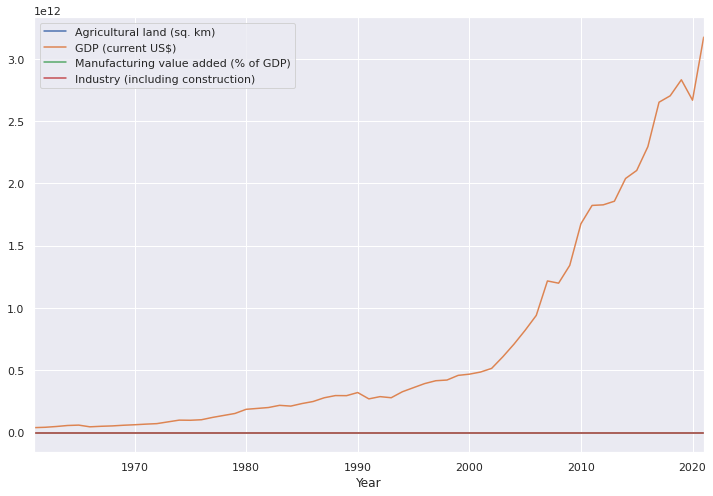

In [12]:
df.plot(figsize=(12,8))

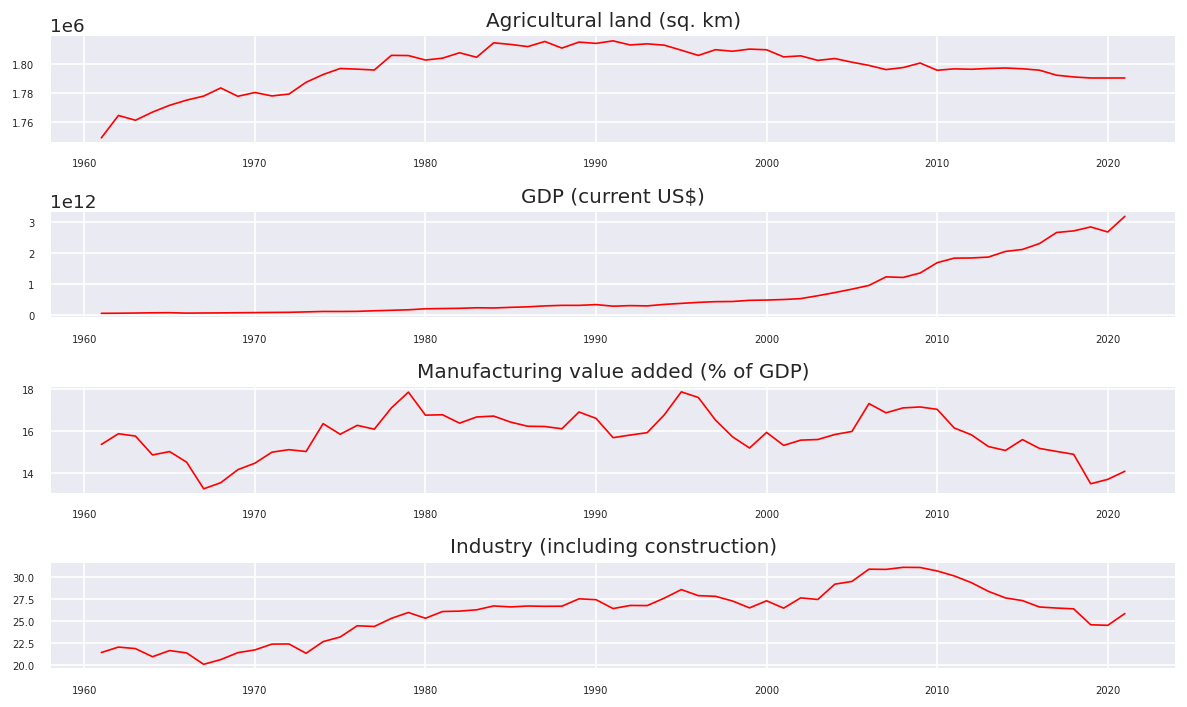

In [13]:
#plot the dataset
fig,axes = plt.subplots(nrows = 4,ncols = 1,dpi = 120,figsize = (10,6))
for i, ax in enumerate(axes.flatten()):
  data = df[df.columns[i]]
  ax.plot(data,color = 'red',linewidth = 1)

  #decorations
  ax.set_title(df.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines["top"].set_alpha(0)
  ax.tick_params(labelsize=6)

plt.tight_layout();

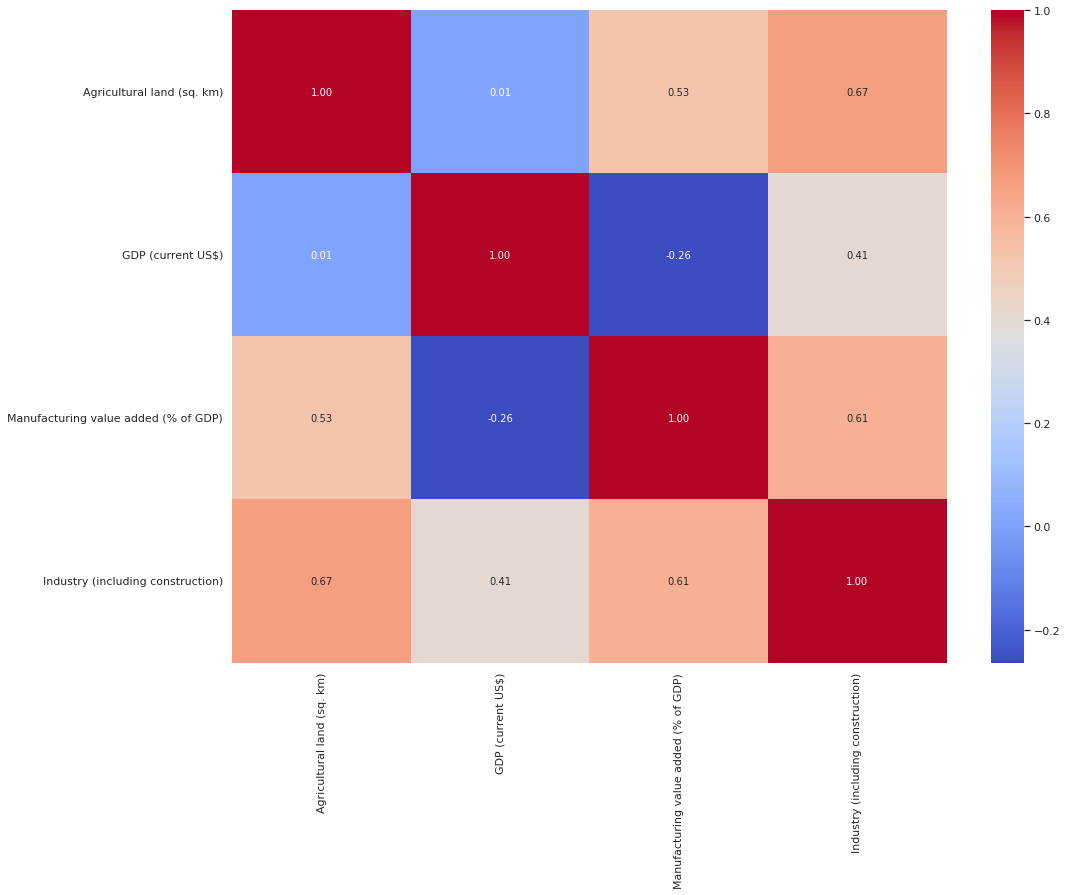

In [14]:
#to find the correlation  between all the columns
plt.figure(figsize=(16,12))
sns.heatmap(data =df.corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

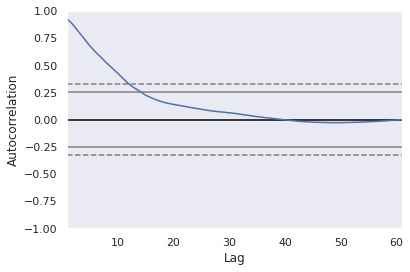

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df)
plt.show()

# TO TEST IF THE TIME SERIES IS STATIONARY OR NO?

In [16]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(df['Agricultural land (sq. km)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.103007
p-value                  0.026331
# lags used             11.000000
# observations          49.000000
critical value (1%)     -3.571472
critical value (5%)     -2.922629
critical value (10%)    -2.599336
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [18]:
adf_test(df['GDP (current US$)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       2.111950
p-value                  0.998802
# lags used             10.000000
# observations          50.000000
critical value (1%)     -3.568486
critical value (5%)     -2.921360
critical value (10%)    -2.598662
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [19]:
adf_test(df['Manufacturing value added (% of GDP)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.990633
p-value                  0.290695
# lags used              0.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
adf_test(df['Industry (including construction)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.602416
p-value                  0.482380
# lags used              0.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


# AS IT IS SEEN THAT COMPLETE DATA IS NOT STATIONARY I.E. P VALUE IS NOT LESS THAN 0.05.
# SO, WE NEED PERFORM 1ST ORDER OF TRANSFORMATION TO MAKE SERIES STATIONARY

# 1ST ORDER OF DIFFERENCING

In [21]:
data_transformed = df.diff().dropna()

WE AGAIN USE ADF TEST TO CHECK IF TIME SERIES IS STATIONARY AFTER 1ST ORDER OF TRANSFORMATION

In [22]:
adf_test(data_transformed['Agricultural land (sq. km)'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.920712e+00
p-value                 2.996193e-17
# lags used             0.000000e+00
# observations          5.900000e+01
critical value (1%)    -3.546395e+00
critical value (5%)    -2.911939e+00
critical value (10%)   -2.593652e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [23]:
adf_test(data_transformed['GDP (current US$)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       1.722156
p-value                  0.998181
# lags used             11.000000
# observations          48.000000
critical value (1%)     -3.574589
critical value (5%)     -2.923954
critical value (10%)    -2.600039
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [24]:
adf_test(data_transformed['Manufacturing value added (% of GDP)'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.454495e+00
p-value                 5.558313e-11
# lags used             0.000000e+00
# observations          5.900000e+01
critical value (1%)    -3.546395e+00
critical value (5%)    -2.911939e+00
critical value (10%)   -2.593652e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [25]:
adf_test(data_transformed['Industry (including construction)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.352134
p-value                  0.000360
# lags used              1.000000
# observations          58.000000
critical value (1%)     -3.548494
critical value (5%)     -2.912837
critical value (10%)    -2.594129
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# FROM THE RESULT WE GET WE CAN CLEARLY SEE THAT ALL THGE FEATURES ARE STATIONARY LEAVING GDP AS P VALUE FOR GDP IS STILL LESS THAN 0.05

# SO, NOW WE APPLY 2ND ORDER OF TRANSFORMATION ON THE ENTIRE DATA.

# 2ND ORDER OF TRANSFORMATION FOLLOWED BY ADF TEST TO CHECK IF THE TIME SERIES HAS BECOME STATIONARY OR NO.

In [26]:
df_transformed = data_transformed.diff().dropna()

In [27]:
adf_test(df_transformed['Agricultural land (sq. km)'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.923045e+00
p-value                 1.133530e-09
# lags used             4.000000e+00
# observations          5.400000e+01
critical value (1%)    -3.557709e+00
critical value (5%)    -2.916770e+00
critical value (10%)   -2.596222e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [28]:
adf_test(df_transformed['GDP (current US$)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.101533
p-value                  0.243898
# lags used             11.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [29]:
adf_test(df_transformed['Manufacturing value added (% of GDP)'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.757594e+00
p-value                 2.845604e-09
# lags used             4.000000e+00
# observations          5.400000e+01
critical value (1%)    -3.557709e+00
critical value (5%)    -2.916770e+00
critical value (10%)   -2.596222e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [30]:
adf_test(df_transformed['Industry (including construction)'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.916577e+00
p-value                 1.068697e-14
# lags used             1.000000e+00
# observations          5.700000e+01
critical value (1%)    -3.550670e+00
critical value (5%)    -2.913766e+00
critical value (10%)   -2.594624e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# FROM THE RESULT WE GET WE CAN CLEARLY SEE THAT ALL THGE FEATURES ARE STATIONARY LEAVING GDP AS P VALUE FOR GDP IS STILL LESS THAN 0.05

# SO, NOW WE APPLY 3RD ORDER OF TRANSFORMATION ON THE ENTIRE DATA.

# 3RD ORDER OF TRANSFORMATION FOLLOWED BY ADF TEST TO CHECK IF THE TIME SERIES HAS BECOME STATIONARY OR NO.

In [31]:
df_transformed = df_transformed.diff().dropna()

In [32]:
adf_test(df_transformed['Agricultural land (sq. km)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.336356
p-value                  0.000005
# lags used             11.000000
# observations          46.000000
critical value (1%)     -3.581258
critical value (5%)     -2.926785
critical value (10%)    -2.601541
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [33]:
adf_test(df_transformed['GDP (current US$)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.797248
p-value                  0.000055
# lags used             11.000000
# observations          46.000000
critical value (1%)     -3.581258
critical value (5%)     -2.926785
critical value (10%)    -2.601541
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [34]:
adf_test(df_transformed['Manufacturing value added (% of GDP)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.605125
p-value                  0.000001
# lags used              6.000000
# observations          51.000000
critical value (1%)     -3.565624
critical value (5%)     -2.920142
critical value (10%)    -2.598015
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [35]:
adf_test(df_transformed['Industry (including construction)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.151497
p-value                  0.000011
# lags used              6.000000
# observations          51.000000
critical value (1%)     -3.565624
critical value (5%)     -2.920142
critical value (10%)    -2.598015
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [36]:
#DROP NA VALUES AS THERE ARE FEW NA VALUES VISIBLE AFTER 3RD ORDER OF TRANSFORMATION
df_transformed

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction)
Year,,,,
1964-01-01,27440.000,-1.533471e+09,-0.170367,0.039817
1965-01-01,-9790.000,-6.781727e+09,1.852555,2.375067
1966-01-01,-190.000,-1.178016e+10,-1.728899,-2.592308
1967-01-01,360.000,3.472283e+10,-0.098134,-0.060382
1968-01-01,3560.000,-1.927784e+10,2.328275,2.863533
1969-01-01,-14090.000,3.730992e+09,-1.230302,-1.582151
1970-01-01,19610.000,-3.800077e+09,-0.646367,-0.731240
1971-01-01,-13270.000,2.342068e+09,0.529278,0.829418
1972-01-01,8590.000,-1.770316e+09,-0.621147,-0.997578


In [37]:
df_transformed.shape

(58, 4)

In [38]:
datanew = df_transformed[df_transformed.columns[i]]

# PLOTTING OF ACF AND PACF GRAPHS 

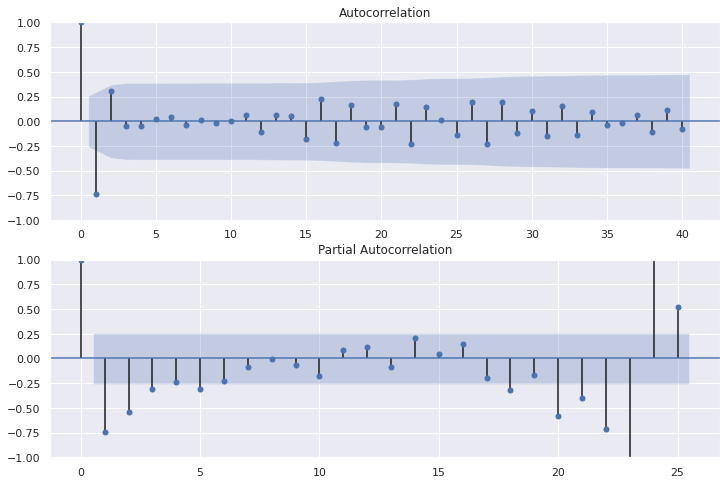

In [39]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(datanew.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(datanew, lags=25, ax=ax2)

# TEST AND TRAIN DATA SPLIT

In [40]:
nobs = 46

In [41]:
train = df_transformed[:nobs]

In [42]:
test = df_transformed[nobs:]

In [43]:
train

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction)
Year,,,,
1964-01-01,27440.0,-1.533471e+09,-0.170367,0.039817
1965-01-01,-9790.0,-6.781727e+09,1.852555,2.375067
1966-01-01,-190.0,-1.178016e+10,-1.728899,-2.592308
1967-01-01,360.0,3.472283e+10,-0.098134,-0.060382
1968-01-01,3560.0,-1.927784e+10,2.328275,2.863533
1969-01-01,-14090.0,3.730992e+09,-1.230302,-1.582151
1970-01-01,19610.0,-3.800077e+09,-0.646367,-0.731240
1971-01-01,-13270.0,2.342068e+09,0.529278,0.829418
1972-01-01,8590.0,-1.770316e+09,-0.621147,-0.997578


In [44]:
test

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction)
Year,,,,
2010-01-01,-9800.000,2.991000e+10,0.030656,-0.132119
2011-01-01,13980.000,-3.770400e+11,-0.618406,0.213842
2012-01-01,-7170.000,4.346000e+10,1.345136,-0.032649
2013-01-01,2090.000,1.673300e+11,-0.809668,-0.030722
2014-01-01,-1100.000,1.288400e+11,0.617934,0.475606
2015-01-01,-570.000,-2.712800e+11,0.329289,0.194359
2016-01-01,390.000,2.447000e+11,-1.645639,-0.858870
2017-01-01,-2013.960,3.871000e+10,1.217521,1.028790
2018-01-01,4677.520,-4.706700e+11,-0.270329,-0.578350


# TO GET P AND Q VALUES

In [45]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import pmdarima as pm

In [47]:
from pmdarima.arima import auto_arima

arima_model=auto_arima(datanew,start_p=1,d=1,start_q=1,
                       max_p=5,max_q=5,max_d=5,m=12,
                       start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                       seasonal=True,
                       trace=True,
                       error_action="ignore",
                       suppress_warnings=True,
                       stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=280.478, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=223.293, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=237.598, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=221.418, Time=0.61 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=222.886, Time=0.69 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=223.072, Time=0.53 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=222.730, Time=0.39 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=266.744, Time=0.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=191.385, Time=0.90 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=190.914, Time=0.45 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=204.351, Time=0.13 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=19

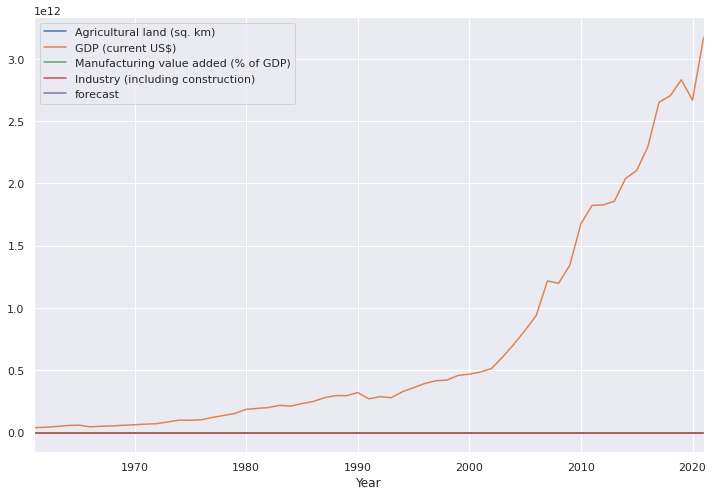

In [48]:
df['forecast']=arima_model.predict(start=90,end=103,dynamic=True)
df[['Agricultural land (sq. km)',	'GDP (current US$)',	'Manufacturing value added (% of GDP)',	'Industry (including construction)','forecast']].plot(figsize=(12,8))

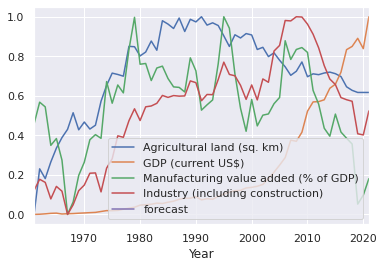

In [49]:
df_norm = (df - df.min())/(df.max()- df.min())
df_norm.plot()

# ARMA MODEL

In [50]:
ar1 = np.array([4,0.33])
ma1 = np.array([0,0.9])

In [51]:
ARMA1 = ArmaProcess(ar1,ma1).generate_sample(nsample=1000)

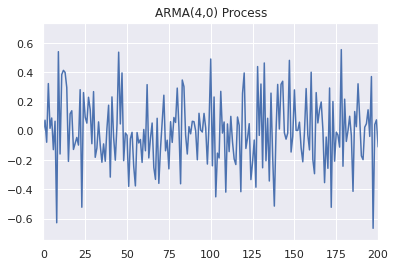

In [52]:
plt.plot(ARMA1)
plt.title('ARMA(4,0) Process')
plt.xlim([0,200])
plt.show()

# from the above model we get p value = 4 and q value = 0

#Gridsearch for order p

# VAR MODEL

In [53]:
model = VAR(train)
for P in [ 1,2,3,4,5,6,7,8]:
  results = model.fit(P)

  print(f'ORDER{P}')
  print(f'AIC{results.aic}')
  print('\n')


ORDER1
AIC67.3076302502678


ORDER2
AIC66.43113174389815


ORDER3
AIC66.30747056978653


ORDER4
AIC66.6185382794587


ORDER5
AIC65.96030617524256


ORDER6
AIC65.14674274601077


ORDER7
AIC63.58713321567597


ORDER8
AIC56.468874564235506




In [54]:
var_model = VARMAX(df_transformed, order=(10,4),enforce_stationarity= True)
results= model.fit(8)

In [55]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Nov, 2022
Time:                     15:18:51
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    62.1573
Nobs:                     38.0000    HQIC:                   58.4928
Log likelihood:          -1156.59    FPE:                1.30638e+26
AIC:                      56.4689    Det(Omega_mle):     1.07194e+25
--------------------------------------------------------------------
Results for equation Agricultural land (sq. km)
                                             coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------------
const                                        -138.931657       540.727312           -0.257           0.797
L1.Agricultural land (sq. km)             

# FORECASTING OF FUTURE VALUES

In [56]:
lagged_values = train.values[-8:]

In [57]:
z = results.forecast(y=lagged_values,steps=12)

In [58]:
z

array([[-6.07003297e+04, -1.46455851e+11,  5.19987266e+00,
         8.27732398e+00],
       [ 1.45810673e+05, -4.07606531e+10, -1.75612278e+01,
        -2.05531134e+01],
       [-1.40913261e+05, -1.82876248e+11,  3.54351478e+01,
         2.96472571e+01],
       [ 4.07429447e+04,  1.01882661e+12, -3.63377840e+01,
        -3.00055296e+01],
       [ 4.16665601e+04, -1.41380146e+12,  1.60337232e+01,
         2.41716071e+01],
       [ 4.04975573e+04,  4.68698559e+11, -1.53433096e+01,
        -3.24643006e+01],
       [-2.62078527e+05,  7.16293943e+11,  5.34177063e+01,
         6.03898455e+01],
       [ 3.30438216e+05,  6.46959413e+10, -9.72913737e+01,
        -8.13907772e+01],
       [-2.32380313e+04, -3.52824481e+12,  9.24641259e+01,
         6.79565818e+01],
       [-3.82243290e+05,  5.94060281e+12, -2.64463564e+01,
        -3.31835068e+01],
       [ 1.93280027e+05, -3.20966565e+12, -6.85704996e+00,
         4.34548466e+01],
       [ 7.19513744e+05, -1.99226560e+12, -1.02344273e+02,
      

In [59]:
idx = pd.date_range('2010-01-01', periods = 12, freq= 'YS')

In [60]:
idx

DatetimeIndex(['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [61]:
df_forecast= pd.DataFrame( data = z, index=idx,columns=['Agricultural land (sq. km)_3d', 'GDP (current US$)_3d','Manufacturing value added (% of GDP)_3d','Industry (including construction)_3d'])

In [62]:
df_forecast

,Agricultural land (sq. km)_3d,GDP (current US$)_3d,Manufacturing value added (% of GDP)_3d,Industry (including construction)_3d
2010-01-01,-60700.329749,-1.464559e+11,5.199873,8.277324
2011-01-01,145810.673229,-4.076065e+10,-17.561228,-20.553113
2012-01-01,-140913.261370,-1.828762e+11,35.435148,29.647257
2013-01-01,40742.944708,1.018827e+12,-36.337784,-30.005530
2014-01-01,41666.560132,-1.413801e+12,16.033723,24.171607
2015-01-01,40497.557290,4.686986e+11,-15.343310,-32.464301
2016-01-01,-262078.527029,7.162939e+11,53.417706,60.389846
2017-01-01,330438.216386,6.469594e+10,-97.291374,-81.390777
2018-01-01,-23238.031339,-3.528245e+12,92.464126,67.956582
2019-01-01,-382243.289828,5.940603e+12,-26.446356,-33.183507


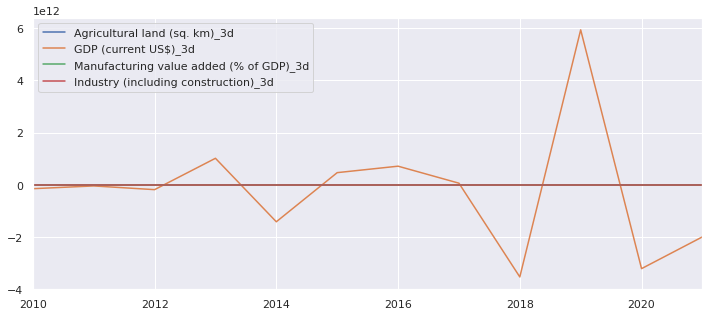

In [63]:
df_forecast.plot(figsize=(12,5))

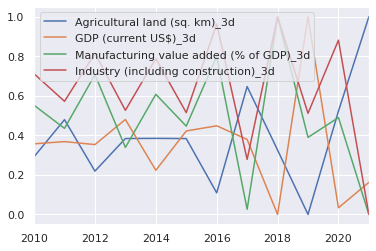

In [64]:
df_forecast = (df_forecast - df_forecast.min())/(df_forecast.max()- df_forecast.min())
df_forecast.plot()

In [65]:
#invert the transformation

In [66]:
df_forecast['Agricultural land (sq. km)2d'] = (df['Agricultural land (sq. km)'].iloc[-nobs-1]-df['Agricultural land (sq. km)'].iloc[-nobs-2]) + df_forecast['Agricultural land (sq. km)_3d'].cumsum()
df_forecast['Agricultural land (sq. km)1d'] = (df['Agricultural land (sq. km)'].iloc[-nobs-1]-df['Agricultural land (sq. km)'].iloc[-nobs-2]) + df_forecast['Agricultural land (sq. km)2d'].cumsum()
df_forecast['Agricultural land (sq. km) forecast'] = df['Agricultural land (sq. km)'].iloc[-nobs-1] + df_forecast['Agricultural land (sq. km)1d'].cumsum()

In [67]:
df_forecast['GDP (current US$)2d'] = (df['GDP (current US$)'].iloc[-nobs-1]-df['GDP (current US$)'].iloc[-nobs-2]) + df_forecast['GDP (current US$)_3d'].cumsum()
df_forecast['GDP (current US$)1d'] = (df['GDP (current US$)'].iloc[-nobs-1]-df['GDP (current US$)'].iloc[-nobs-2]) + df_forecast['GDP (current US$)2d'].cumsum()
df_forecast['GDP (current US$) forecast'] = df['GDP (current US$)'].iloc[-nobs-1] + df_forecast['GDP (current US$)1d'].cumsum()

In [68]:
df_forecast['Manufacturing value added (% of GDP)2d'] = (df['Manufacturing value added (% of GDP)'].iloc[-nobs-1]-df['Manufacturing value added (% of GDP)'].iloc[-nobs-2]) + df_forecast['Manufacturing value added (% of GDP)_3d'].cumsum()
df_forecast['Manufacturing value added (% of GDP)1d'] = (df['Manufacturing value added (% of GDP)'].iloc[-nobs-1]-df['Manufacturing value added (% of GDP)'].iloc[-nobs-2]) + df_forecast['Manufacturing value added (% of GDP)2d'].cumsum()
df_forecast['Manufacturing value added (% of GDP) forecast'] = df['Manufacturing value added (% of GDP)'].iloc[-nobs-1] + df_forecast['Manufacturing value added (% of GDP)1d'].cumsum()

In [69]:
df_forecast['Industry (including construction)2d'] = (df['Industry (including construction)'].iloc[-nobs-1]-df['Industry (including construction)'].iloc[-nobs-2]) + df_forecast['Industry (including construction)_3d'].cumsum()
df_forecast['Industry (including construction)1d'] = (df['Industry (including construction)'].iloc[-nobs-1]-df['Industry (including construction)'].iloc[-nobs-2]) + df_forecast['Industry (including construction)2d'].cumsum()
df_forecast['Industry (including construction) forecast'] = df['Industry (including construction)'].iloc[-nobs-1] + df_forecast['Industry (including construction)1d'].cumsum()

In [70]:
df_forecast.head()

,Agricultural land (sq. km)_3d,GDP (current US$)_3d,Manufacturing value added (% of GDP)_3d,Industry (including construction)_3d,Agricultural land (sq. km)2d,Agricultural land (sq. km)1d,Agricultural land (sq. km) forecast,GDP (current US$)2d,GDP (current US$)1d,GDP (current US$) forecast,Manufacturing value added (% of GDP)2d,Manufacturing value added (% of GDP)1d,Manufacturing value added (% of GDP) forecast,Industry (including construction)2d,Industry (including construction)1d,Industry (including construction) forecast
2010-01-01,0.291846,0.357149,0.552051,0.711618,4120.291846,8240.291846,1.805180e+06,-1.053103e+09,-2.106205e+09,9.636659e+10,0.044624,-0.462803,15.375684,1.237176,1.762735,24.963987
2011-01-01,0.479283,0.368311,0.435212,0.572303,4120.771129,12361.062975,1.817541e+06,-1.053103e+09,-3.159308e+09,9.320728e+10,0.479837,0.017034,15.392718,1.809480,3.572215,28.536202
2012-01-01,0.219041,0.353303,0.707256,0.814882,4120.990170,16482.053145,1.834023e+06,-1.053103e+09,-4.212411e+09,8.899487e+10,1.187093,1.204127,16.596845,2.624361,6.196576,34.732779
2013-01-01,0.383920,0.480214,0.338828,0.526627,4121.374090,20603.427235,1.854627e+06,-1.053103e+09,-5.265513e+09,8.372936e+10,1.525920,2.730047,19.326892,3.150989,9.347565,44.080344
2014-01-01,0.384758,0.223305,0.607664,0.788422,4121.758848,24725.186083,1.879352e+06,-1.053103e+09,-6.318616e+09,7.741074e+10,2.133584,4.863631,24.190523,3.939411,13.286976,57.367320


In [71]:
test_range=df[nobs:]

In [72]:
test_range

,Agricultural land (sq. km),GDP (current US$),Manufacturing value added (% of GDP),Industry (including construction),forecast
Year,,,,,
2007-01-01,1796200.000,1.216740e+12,16.864568,30.903238,NaN
2008-01-01,1797570.000,1.198900e+12,17.098674,31.136719,NaN
2009-01-01,1800680.000,1.341890e+12,17.143578,31.121372,NaN
2010-01-01,1795730.000,1.675620e+12,17.029934,30.725078,NaN
2011-01-01,1796700.000,1.823050e+12,16.139337,30.161680,NaN
2012-01-01,1796420.000,1.827640e+12,15.816923,29.398528,NaN
2013-01-01,1796980.000,1.856720e+12,15.253023,28.404900,NaN
2014-01-01,1797280.000,2.039130e+12,15.065570,27.656401,NaN
2015-01-01,1796750.000,2.103590e+12,15.583855,27.347391,NaN


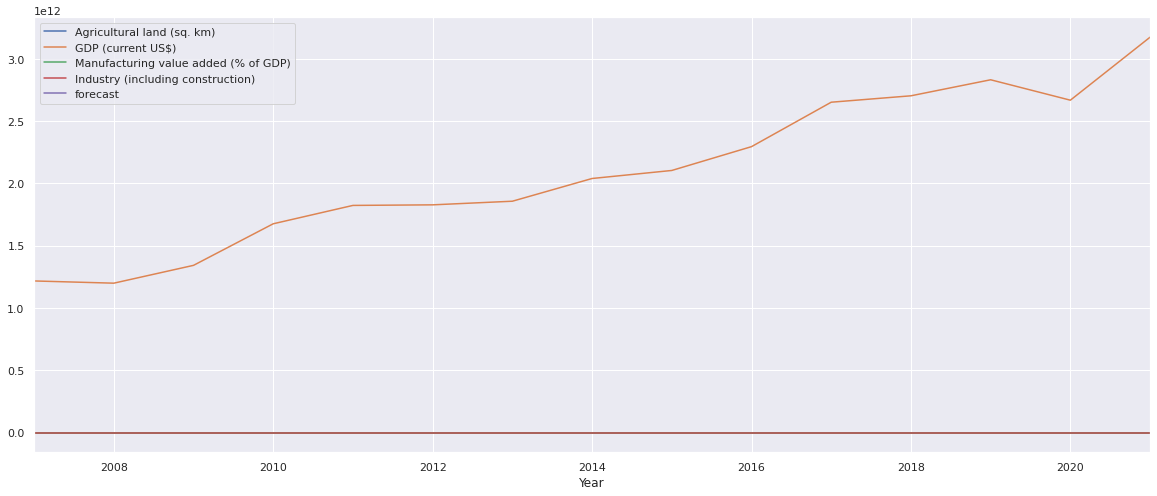

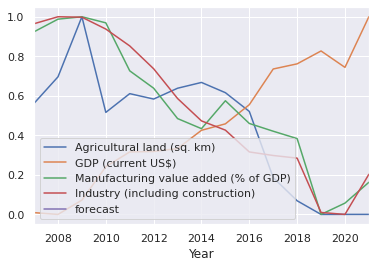

In [73]:
test_range.plot(figsize=(20,8))
df_test_range = (test_range - test_range.min())/(test_range.max()- test_range.min())
df_test_range.plot()

In [74]:
df_forecast.columns

Index(['Agricultural land (sq. km)_3d', 'GDP (current US$)_3d',
       'Manufacturing value added (% of GDP)_3d',
       'Industry (including construction)_3d', 'Agricultural land (sq. km)2d',
       'Agricultural land (sq. km)1d', 'Agricultural land (sq. km) forecast',
       'GDP (current US$)2d', 'GDP (current US$)1d',
       'GDP (current US$) forecast', 'Manufacturing value added (% of GDP)2d',
       'Manufacturing value added (% of GDP)1d',
       'Manufacturing value added (% of GDP) forecast',
       'Industry (including construction)2d',
       'Industry (including construction)1d',
       'Industry (including construction) forecast'],
      dtype='object')

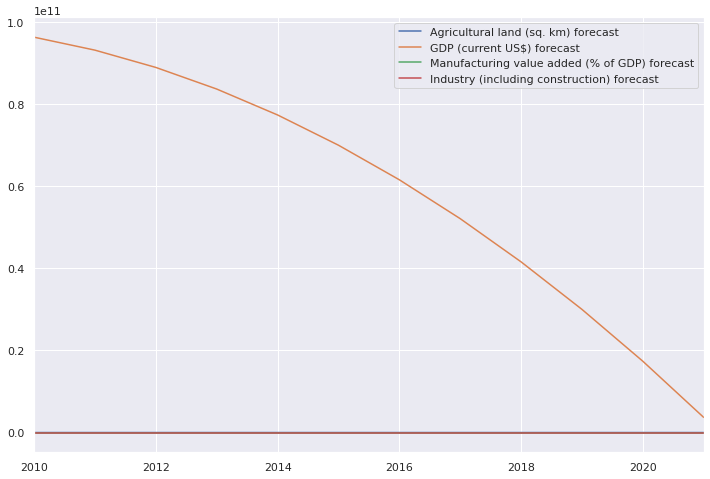

In [75]:
df_forecast[['Agricultural land (sq. km) forecast','GDP (current US$) forecast', 'Manufacturing value added (% of GDP) forecast','Industry (including construction) forecast']].plot(figsize=(12,8))

# COMPARING THE PREDICTED VALUE OF THAT YEAR AND ACTUAL VALUE 

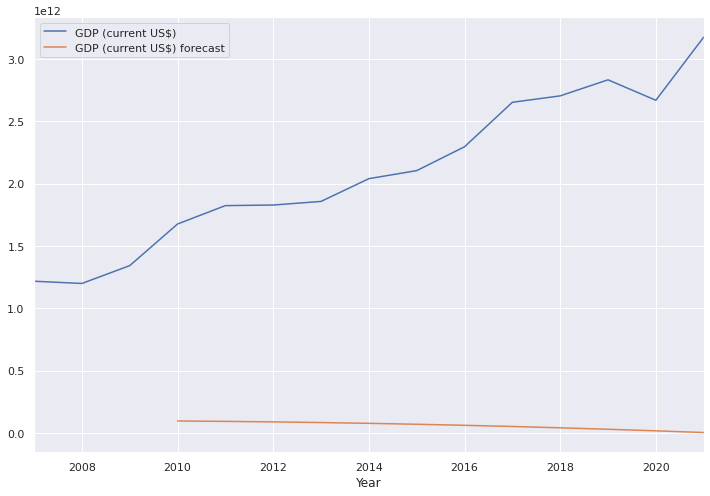

In [76]:
test_range['GDP (current US$)'].plot(figsize=(12,8),legend=True)
df_forecast['GDP (current US$) forecast'].plot(legend=True)

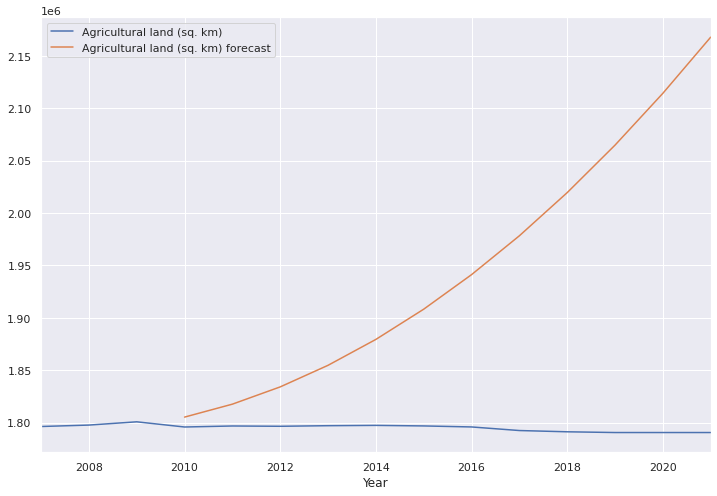

In [77]:
test_range['Agricultural land (sq. km)'].plot(figsize=(12,8),legend=True)
df_forecast['Agricultural land (sq. km) forecast'].plot(legend=True)

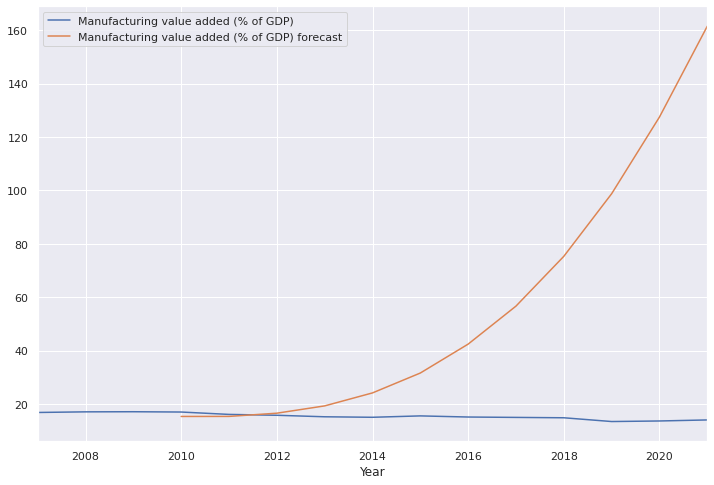

In [78]:
test_range['Manufacturing value added (% of GDP)'].plot(figsize=(12,8),legend=True)
df_forecast['Manufacturing value added (% of GDP) forecast'].plot(legend=True)

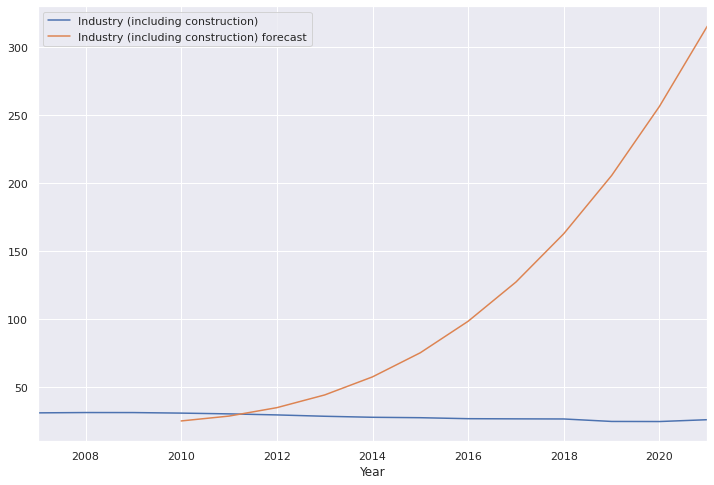

In [79]:
test_range['Industry (including construction)'].plot(figsize=(12,8),legend=True)
df_forecast['Industry (including construction) forecast'].plot(legend=True)

# PREDICTING VALUES FOR NEXT 10 YEARS FROM 2020

In [80]:
lagged_values = train.values[:-8]

In [81]:
z = results.forecast(y=lagged_values,steps=12)

In [82]:
z

array([[ 7.94994686e+03, -9.28069790e+08,  2.24728382e+00,
         3.28033569e+00],
       [-4.53420703e+03,  4.39668829e+10, -1.57063545e+00,
        -3.56458321e+00],
       [ 5.06365395e+03, -6.44580853e+10,  1.45769854e+00,
         4.25363025e+00],
       [-8.23654108e+03,  3.22027695e+10, -1.61197229e+00,
        -4.27356269e+00],
       [ 7.30255559e+03, -4.83930112e+10,  2.18931401e+00,
         3.59790499e+00],
       [-3.64202633e+03,  1.79219761e+11, -3.21766411e+00,
        -3.40926705e+00],
       [ 9.37306406e+02, -3.99443593e+11,  2.93056352e+00,
         2.31431705e+00],
       [ 8.95693392e+03,  4.09158095e+11, -2.36640369e+00,
        -2.15738623e+00],
       [-6.06582100e+04, -1.92226104e+11,  6.96956440e+00,
         9.54944276e+00],
       [ 1.21067707e+05,  9.89614901e+10, -1.80771369e+01,
        -2.00766696e+01],
       [-1.14898693e+05, -3.45900245e+11,  3.19963233e+01,
         2.76215193e+01],
       [ 4.61289996e+04,  9.61461637e+11, -3.34312115e+01,
      

In [83]:
idx = pd.date_range('2020-01-01', periods = 12, freq= 'YS')

In [84]:
idx

DatetimeIndex(['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01',
               '2028-01-01', '2029-01-01', '2030-01-01', '2031-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [85]:
df_forecast= pd.DataFrame( data = z, index=idx,columns=['Agricultural land (sq. km)_3d', 'GDP (current US$)_3d','Manufacturing value added (% of GDP)_3d','Industry (including construction)_3d'])

In [86]:
df_forecast

,Agricultural land (sq. km)_3d,GDP (current US$)_3d,Manufacturing value added (% of GDP)_3d,Industry (including construction)_3d
2020-01-01,7949.946857,-9.280698e+08,2.247284,3.280336
2021-01-01,-4534.207029,4.396688e+10,-1.570635,-3.564583
2022-01-01,5063.653946,-6.445809e+10,1.457699,4.253630
2023-01-01,-8236.541077,3.220277e+10,-1.611972,-4.273563
2024-01-01,7302.555595,-4.839301e+10,2.189314,3.597905
2025-01-01,-3642.026325,1.792198e+11,-3.217664,-3.409267
2026-01-01,937.306406,-3.994436e+11,2.930564,2.314317
2027-01-01,8956.933923,4.091581e+11,-2.366404,-2.157386
2028-01-01,-60658.209989,-1.922261e+11,6.969564,9.549443
2029-01-01,121067.707298,9.896149e+10,-18.077137,-20.076670


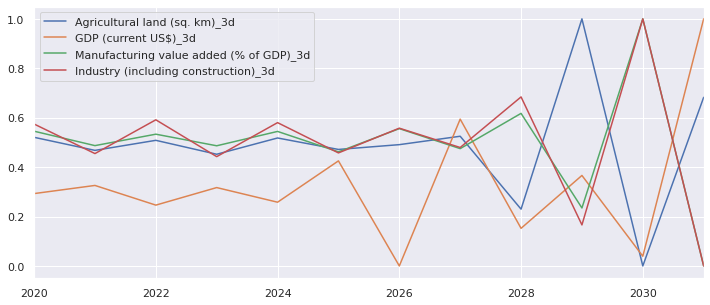

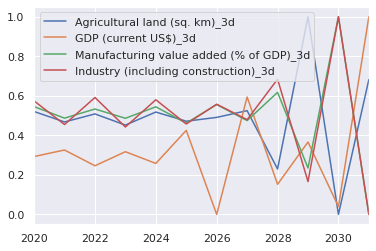

In [89]:
df_forecast.plot(figsize=(12,5))
df_forecast = (df_forecast - df_forecast.min())/(df_forecast.max()- df_forecast.min())
df_forecast.plot()